In [55]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.fft 
import pmdarima as pm
import itertools

os.chdir('/home/etienne/data/spikes')
spikes3=pd.read_csv('spikesrat3.csv')

In [3]:
import cv2
def window(spikes,delta):
    '''
    Entry: number of spikes per hour
           delta which is the number of time points chosen to average
           
    Return: the unweighted downsampled temporal network of new size (time points)/delta
    '''
    Filter=np.ones((delta,))/delta

    m=np.convolve(spikes,Filter,mode='valid')[::delta]
    return(m)

In [4]:
np.array(spikes3).shape

(1597, 1)

In [5]:
spikes=np.array(spikes3)[:,0]
delta=24

Filter=np.ones((delta,))/delta

spikespd=window(spikes,24)

<BarContainer object of 55 artists>

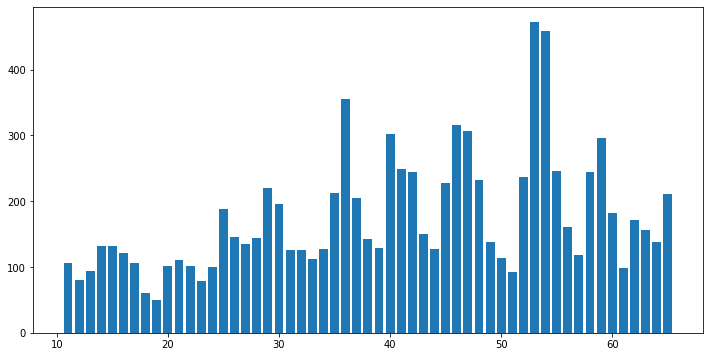

In [11]:
plt.figure(figsize=(12,6))
plt.bar(np.arange(11,len(spikespd)),spikespd[11:len(spikespd)])

In [7]:
signal=spikespd[11:len(spikespd)]

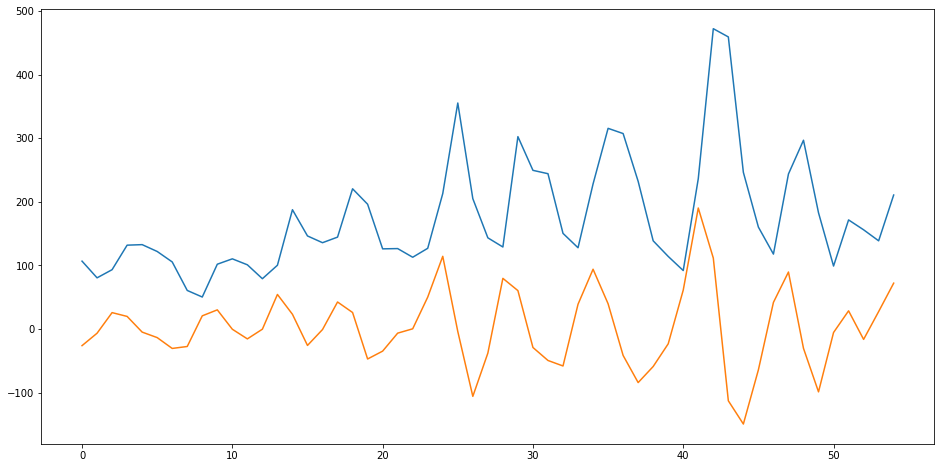

In [10]:
plt.figure(figsize=(16,8))
plt.plot(signal)
plt.plot(np.gradient(signal))

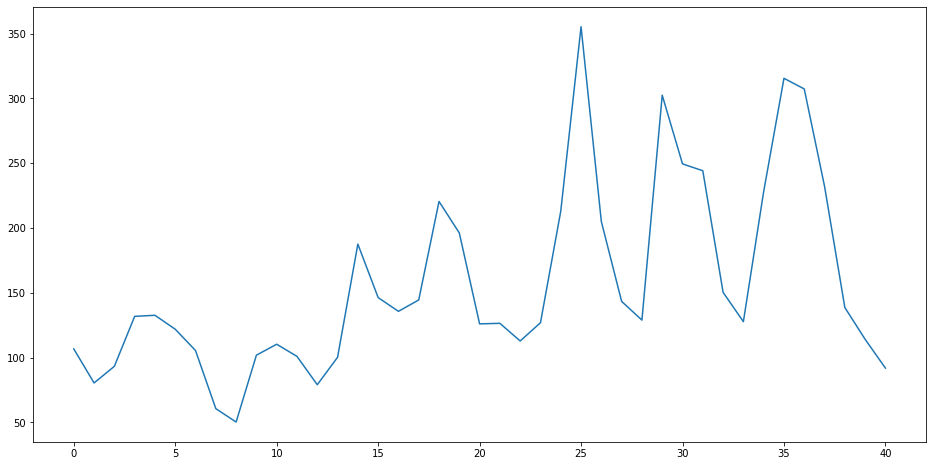

In [8]:
plt.figure(figsize=(16,8))
plt.plot(signal)

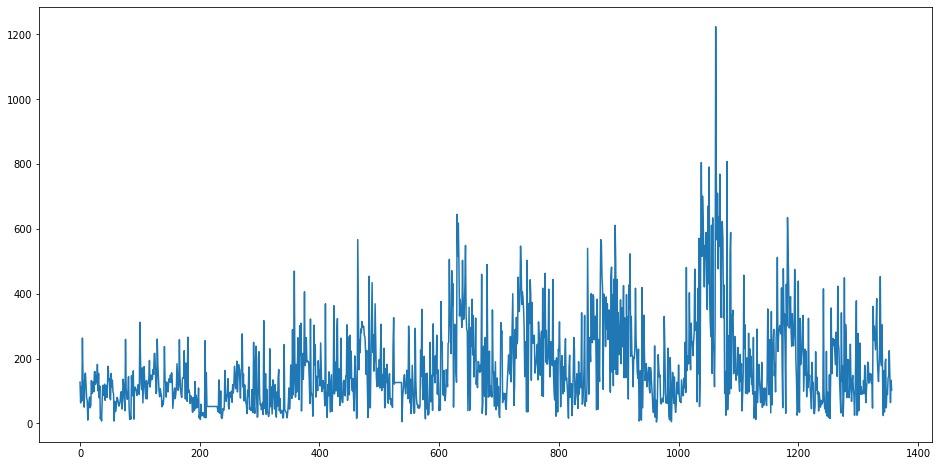

In [12]:
plt.figure(figsize=(16,8))
plt.plot(spikes[240:])

In [25]:
from scipy.fft import fft, fftfreq, fftshift
spikesf=spikes[240:]
DFT=fft(spikesf)

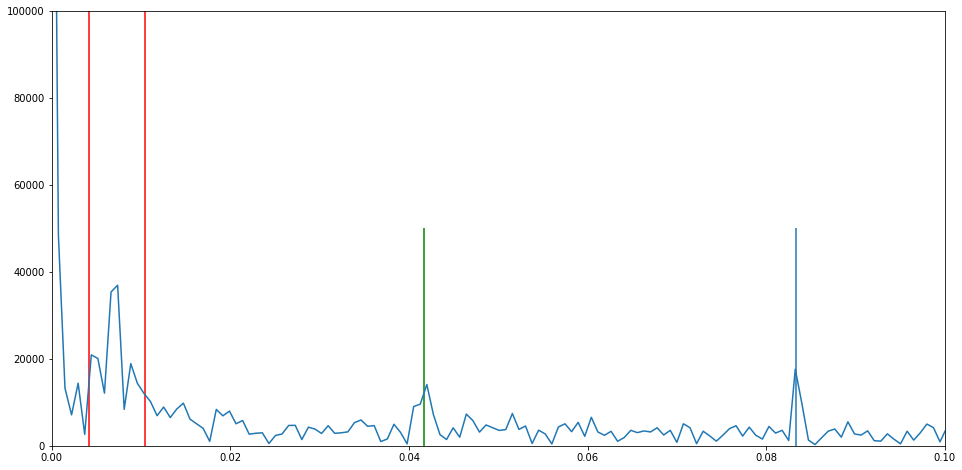

In [48]:
sp=fftshift(DFT)
freq = fftshift(fftfreq(spikesf.shape[-1]))

plt.figure(figsize=(16,8))
plt.plot(freq, np.sqrt((sp.imag)**2 +(sp.real)**2))
plt.xlim((0,0.1))
plt.ylim((0,100000))

plt.vlines(1/12,0,50000)
plt.vlines(1/24,0,50000,colors='g')

plt.vlines(1/(24*4),0,100000,colors='r')
plt.vlines(1/(24*10),0,100000,colors='r')


<Figure size 1152x576 with 0 Axes>

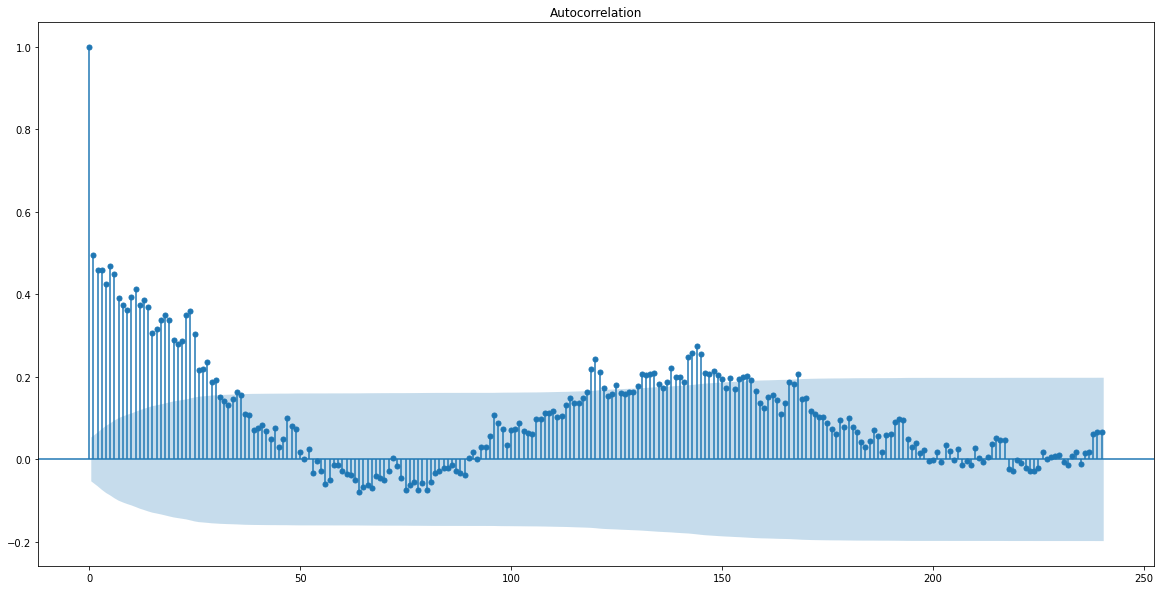

In [58]:
from statsmodels.graphics import tsaplots

plt.rc("figure", figsize=(20,10))
plt.figure(figsize=(16,8))
tsaplots.plot_acf(spikesf,lags=240)

plt.show()

In [45]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

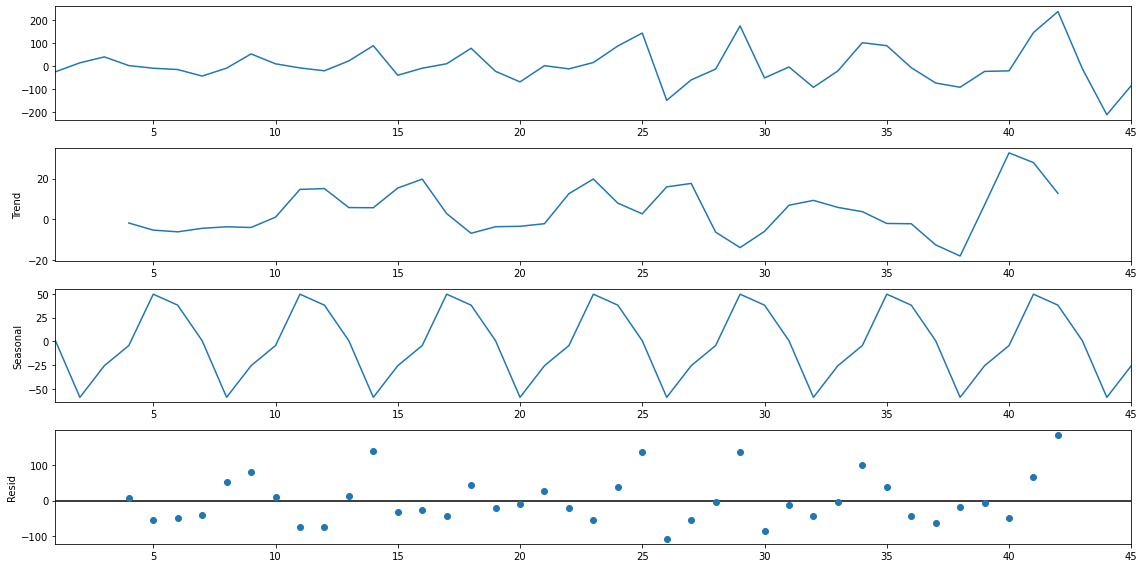

In [42]:
from pylab import rcParams
import statsmodels.api as sm

n=9
train=pd.DataFrame(signal[:55-n])

rcParams['figure.figsize']=16,8
decomposition = sm.tsa.seasonal_decompose(train.diff()[1:], model='additive',period=6)
fig = decomposition.plot()
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -7.394025e+00
p-value                        7.863991e-11
#Lags Used                     5.000000e+00
Number of Observations Used    3.800000e+01
Critical Value (1%)           -3.615509e+00
Critical Value (5%)           -2.941262e+00
Critical Value (10%)          -2.609200e+00
dtype: float64


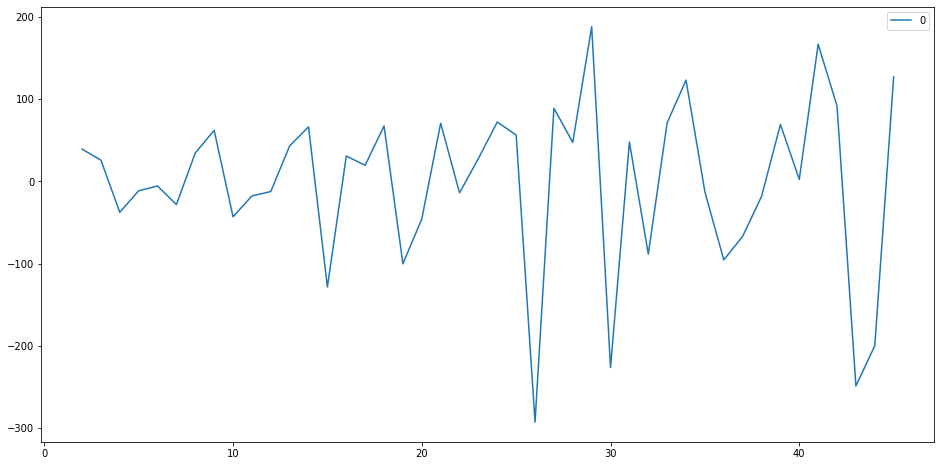

In [51]:
grad=train.diff()[1:]
ts_t_adj=grad-grad.shift(1)
ts_t_adj=ts_t_adj.dropna()

ts_t_adj.plot()
adf_test(ts_t_adj) 

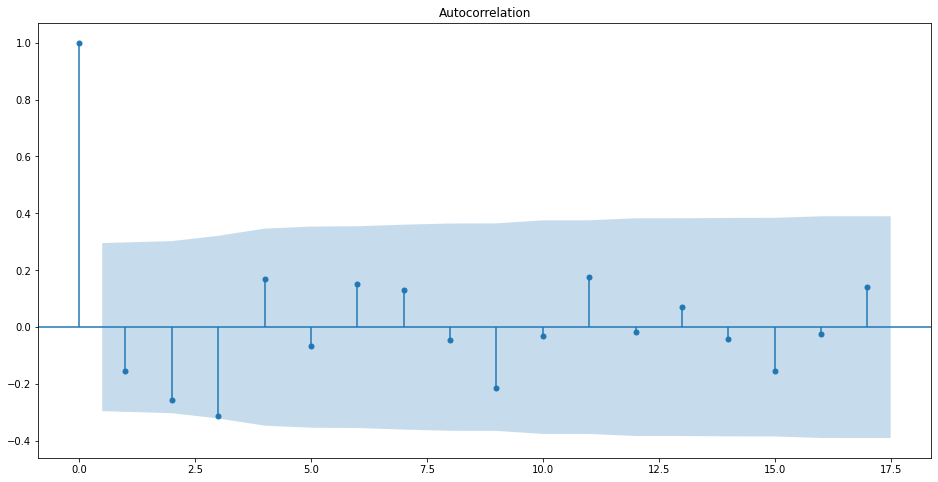

/home/etienne/env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


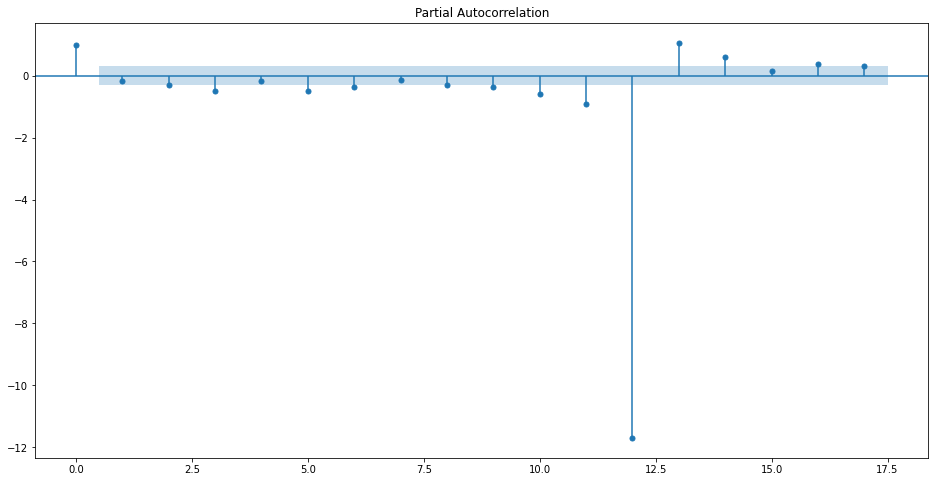

In [74]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_t_adj)
plt.show()
plot_pacf(ts_t_adj)
plt.show()

In [80]:
p = range(0, 3)
d = range(1,2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]


for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_t_adj,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}6 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-pac

ARIMA(0, 1, 0)x(0, 1, 0, 6)6 - AIC:489.2351211794365
ARIMA(0, 1, 0)x(0, 1, 1, 6)6 - AIC:403.49764611947484


/home/etienne/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsm

ARIMA(0, 1, 0)x(0, 1, 2, 6)6 - AIC:846.0214977689977
ARIMA(0, 1, 0)x(1, 1, 0, 6)6 - AIC:424.7503586056177
ARIMA(0, 1, 0)x(1, 1, 1, 6)6 - AIC:405.48445178905376
ARIMA(0, 1, 0)x(1, 1, 2, 6)6 - AIC:327.6181551379327
ARIMA(0, 1, 0)x(2, 1, 0, 6)6 - AIC:338.09833458712023
ARIMA(0, 1, 0)x(2, 1, 1, 6)6 - AIC:340.075825021547


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-pac

ARIMA(0, 1, 0)x(2, 1, 2, 6)6 - AIC:326.94522673733377
ARIMA(0, 1, 1)x(0, 1, 0, 6)6 - AIC:447.6417660433809
ARIMA(0, 1, 1)x(0, 1, 1, 6)6 - AIC:368.8268941083506


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-pac

ARIMA(0, 1, 1)x(0, 1, 2, 6)6 - AIC:1033.8375790277205
ARIMA(0, 1, 1)x(1, 1, 0, 6)6 - AIC:399.7735281367363
ARIMA(0, 1, 1)x(1, 1, 1, 6)6 - AIC:370.8267163989584


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-pac

ARIMA(0, 1, 1)x(1, 1, 2, 6)6 - AIC:299.42796237662003
ARIMA(0, 1, 1)x(2, 1, 0, 6)6 - AIC:321.6874049256449


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


ARIMA(0, 1, 1)x(2, 1, 1, 6)6 - AIC:323.6811710829611
ARIMA(0, 1, 1)x(2, 1, 2, 6)6 - AIC:297.5468518953417


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


ARIMA(0, 1, 2)x(0, 1, 0, 6)6 - AIC:418.31164053708824
ARIMA(0, 1, 2)x(0, 1, 1, 6)6 - AIC:345.14866048397374


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-pac

ARIMA(0, 1, 2)x(0, 1, 2, 6)6 - AIC:345.2077309060743
ARIMA(0, 1, 2)x(1, 1, 0, 6)6 - AIC:386.15661526757236


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


ARIMA(0, 1, 2)x(1, 1, 1, 6)6 - AIC:347.1483051716281
ARIMA(0, 1, 2)x(1, 1, 2, 6)6 - AIC:278.1916412667764


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


ARIMA(0, 1, 2)x(2, 1, 0, 6)6 - AIC:313.8146321856408


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


ARIMA(0, 1, 2)x(2, 1, 1, 6)6 - AIC:314.40109463048066


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsm

ARIMA(0, 1, 2)x(2, 1, 2, 6)6 - AIC:282.0392014353256
ARIMA(1, 1, 0)x(0, 1, 0, 6)6 - AIC:480.7823124008019
ARIMA(1, 1, 0)x(0, 1, 1, 6)6 - AIC:397.4864844143945


/home/etienne/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsm

ARIMA(1, 1, 0)x(0, 1, 2, 6)6 - AIC:1043.9296323879635
ARIMA(1, 1, 0)x(1, 1, 0, 6)6 - AIC:403.0490477860951
ARIMA(1, 1, 0)x(1, 1, 1, 6)6 - AIC:399.4759181123078
ARIMA(1, 1, 0)x(1, 1, 2, 6)6 - AIC:324.51330960896973
ARIMA(1, 1, 0)x(2, 1, 0, 6)6 - AIC:321.4895553936268
ARIMA(1, 1, 0)x(2, 1, 1, 6)6 - AIC:322.95693976489235


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-pac

ARIMA(1, 1, 0)x(2, 1, 2, 6)6 - AIC:323.76098634092926
ARIMA(1, 1, 1)x(0, 1, 0, 6)6 - AIC:446.3366953680647
ARIMA(1, 1, 1)x(0, 1, 1, 6)6 - AIC:369.1025720636737


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-pac

ARIMA(1, 1, 1)x(0, 1, 2, 6)6 - AIC:10.0
ARIMA(1, 1, 1)x(1, 1, 0, 6)6 - AIC:385.2564770933167


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


ARIMA(1, 1, 1)x(1, 1, 1, 6)6 - AIC:371.10076015948147


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


ARIMA(1, 1, 1)x(1, 1, 2, 6)6 - AIC:300.2866430836711
ARIMA(1, 1, 1)x(2, 1, 0, 6)6 - AIC:309.06713005872757


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


ARIMA(1, 1, 1)x(2, 1, 1, 6)6 - AIC:311.0100433936143
ARIMA(1, 1, 1)x(2, 1, 2, 6)6 - AIC:298.8290036854244


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


ARIMA(1, 1, 2)x(0, 1, 0, 6)6 - AIC:420.31104380115744
ARIMA(1, 1, 2)x(0, 1, 1, 6)6 - AIC:347.01225938904514


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-pac

ARIMA(1, 1, 2)x(0, 1, 2, 6)6 - AIC:1358.677868730983


/home/etienne/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


ARIMA(1, 1, 2)x(1, 1, 0, 6)6 - AIC:375.1460953092517
ARIMA(1, 1, 2)x(1, 1, 1, 6)6 - AIC:349.01208804473424


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


ARIMA(1, 1, 2)x(1, 1, 2, 6)6 - AIC:280.1306452799205


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


ARIMA(1, 1, 2)x(2, 1, 0, 6)6 - AIC:302.81783145108477


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


ARIMA(1, 1, 2)x(2, 1, 1, 6)6 - AIC:304.8132237203271


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsm

ARIMA(1, 1, 2)x(2, 1, 2, 6)6 - AIC:282.71369087199434
ARIMA(2, 1, 0)x(0, 1, 0, 6)6 - AIC:462.0490420362709
ARIMA(2, 1, 0)x(0, 1, 1, 6)6 - AIC:394.4875381513969


/home/etienne/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsm

ARIMA(2, 1, 0)x(0, 1, 2, 6)6 - AIC:1082.2857024284326
ARIMA(2, 1, 0)x(1, 1, 0, 6)6 - AIC:386.173183792899
ARIMA(2, 1, 0)x(1, 1, 1, 6)6 - AIC:384.1300288215329
ARIMA(2, 1, 0)x(1, 1, 2, 6)6 - AIC:322.0735482183169
ARIMA(2, 1, 0)x(2, 1, 0, 6)6 - AIC:306.96878686900186


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


ARIMA(2, 1, 0)x(2, 1, 1, 6)6 - AIC:308.88741927685686
ARIMA(2, 1, 0)x(2, 1, 2, 6)6 - AIC:308.4540582210067


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-pac

ARIMA(2, 1, 1)x(0, 1, 0, 6)6 - AIC:440.9295038471315
ARIMA(2, 1, 1)x(0, 1, 1, 6)6 - AIC:366.9887580857986


/home/etienne/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsm

ARIMA(2, 1, 1)x(0, 1, 2, 6)6 - AIC:1834.424075441647
ARIMA(2, 1, 1)x(1, 1, 0, 6)6 - AIC:370.1080078632814
ARIMA(2, 1, 1)x(1, 1, 1, 6)6 - AIC:368.9732751136437


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


ARIMA(2, 1, 1)x(1, 1, 2, 6)6 - AIC:298.56104992998445
ARIMA(2, 1, 1)x(2, 1, 0, 6)6 - AIC:294.64019605352394


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


ARIMA(2, 1, 1)x(2, 1, 1, 6)6 - AIC:296.28063409506336


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


ARIMA(2, 1, 1)x(2, 1, 2, 6)6 - AIC:296.37198280075296
ARIMA(2, 1, 2)x(0, 1, 0, 6)6 - AIC:415.56964693664406


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


ARIMA(2, 1, 2)x(0, 1, 1, 6)6 - AIC:343.16445582037915


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsm

ARIMA(2, 1, 2)x(0, 1, 2, 6)6 - AIC:943.6160498632438
ARIMA(2, 1, 2)x(1, 1, 0, 6)6 - AIC:358.3407965833158


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


ARIMA(2, 1, 2)x(1, 1, 1, 6)6 - AIC:345.16441984158126


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsm

ARIMA(2, 1, 2)x(1, 1, 2, 6)6 - AIC:275.06880768331314
ARIMA(2, 1, 2)x(2, 1, 0, 6)6 - AIC:288.06550065011317


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsm

ARIMA(2, 1, 2)x(2, 1, 1, 6)6 - AIC:290.7203761430629
ARIMA(2, 1, 2)x(2, 1, 2, 6)6 - AIC:279.099252306619


/home/etienne/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [82]:
mod = sm.tsa.statespace.SARIMAX(ts_t_adj,order=(1,1,1),seasonal_order=(0,1,2,6))
results = mod.fit(method = 'powell')
print(results.summary().tables[1])

Optimization terminated successfully.
         Current function value: 5.207399
         Iterations: 3
         Function evaluations: 188
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2452      0.211     -1.161      0.245      -0.659       0.169
ma.L1         -0.9991     27.269     -0.037      0.971     -54.446      52.447
ma.S.L6       -0.4974      0.255     -1.951      0.051      -0.997       0.002
ma.S.L12      -0.1029      0.245     -0.421      0.674      -0.582       0.377
sigma2      1.147e+04   3.13e+05      0.037      0.971   -6.01e+05    6.24e+05


/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/etienne/env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [84]:
results

TypeError: 'int' object is not subscriptable

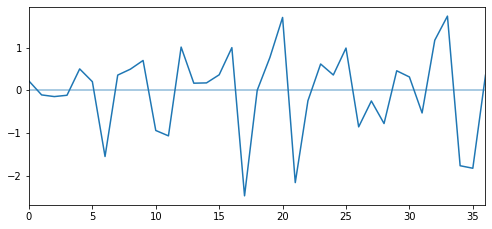

In [83]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()
